**Image Classification Blood Cells**

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aldisusanto","key":"12128342aae2a8f9aa0e4076c41d4887"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Dowload dataset 
!kaggle datasets download -d paultimothymooney/blood-cells

 76% 82.0M/108M [00:00<00:00, 237MB/s]
100% 108M/108M [00:00<00:00, 225MB/s] 


In [30]:
import zipfile
import os
import glob 
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [11]:
# Ekstrak zip 
zip = 'blood-cells.zip'
ekstrak_zip = zipfile.ZipFile(zip, 'r')
ekstrak_zip.extractall('/dataset')
ekstrak_zip.close()


In [18]:
# Dataset directory
train_dir = '/dataset/dataset2-master/dataset2-master/images/TRAIN'
test_dir = '/dataset/dataset2-master/dataset2-master/images/TEST'

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)
val_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [31]:
# Pembuatan Model dengan tipe Sequential

Model = Sequential(
    [
     # Activation menggunakan relu + softmax
     Conv2D(32, 3, activation = 'relu' , input_shape = (224,224,3)),
     BatchNormalization(),
     Conv2D(64, 3, activation = 'relu' ),
     MaxPooling2D(2),
     Conv2D(128, 3,  activation = 'relu' ),
     Dropout(0.5),
     GlobalAveragePooling2D(),
     Flatten(),
     Dense(256, activation = 'relu'),
     Dropout(0.5),
     Dense(4, activation='softmax')
    ]
)

In [32]:
Model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [33]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [34]:
history = Model.fit(train_generator,
                      validation_data=val_generator,
                      callbacks=[lr_schedule, tb_callback],
                      epochs=20)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
249/249 [==============================] - 85s 328ms/step - loss: 1.1980 - accuracy: 0.4322 - val_loss: 1.2934 - val_accuracy: 0.3595 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
249/249 [==============================] - 81s 323ms/step - loss: 0.8776 - accuracy: 0.6280 - val_loss: 0.8683 - val_accuracy: 0.6752 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
249/249 [==============================] - 81s 323ms/step - loss: 0.7077 - accuracy: 0.7022 - val_loss: 0.5931 - val_accuracy: 0.7310 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
249/249 [==============================] - 81s 323ms/step - loss: 0.5732 - accuracy: 0.7609 - val_loss: 2.6084 - val_accuracy: 0.3067 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning

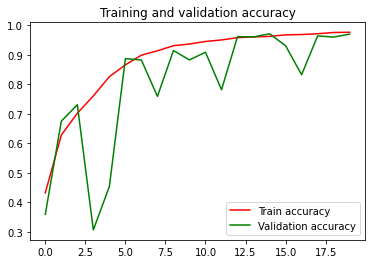

<Figure size 432x288 with 0 Axes>

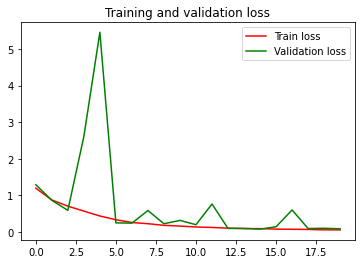

<Figure size 432x288 with 0 Axes>

In [35]:
# Mengambil Nilai Accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Mengambil Nilai Loss 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accruracy
plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [36]:
# Menghilangkan Warning
warnings.filterwarnings('ignore')

# Convert Model.
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()

# Save the model.
with open('RPS_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprgzungc7/assets
